# <makedowncell>
# # Sentiment Analysis with an RNN
# 
# In this notebook, you'll implement a recurrent neural network that performs sentiment analysis. Using an RNN rather than a feedfoward network is more accurate since we can include information about the *sequence* of words. Here we'll use a dataset of movie reviews, accompanied by labels.
# 
# The architecture for this network is shown below.
# 
# <img src="assets/network_diagram.png" width=400px>
# 
# Here, we'll pass in words to an embedding layer. We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. You should have seen this before from the word2vec lesson. You can actually train up an embedding with word2vec and use it here. But it's good enough to just have an embedding layer and let the network learn the embedding table on it's own.
# 
# From the embedding layer, the new representations will be passed to LSTM cells. These will add recurrent connections to the network so we can include information about the sequence of words in the data. Finally, the LSTM cells will go to a sigmoid output layer here. We're using the sigmoid because we're trying to predict if this text has positive or negative sentiment. The output layer will just be a single unit then, with a sigmoid activation function.
# 
# We don't care about the sigmoid outputs except for the very last one, we can ignore the rest. We'll calculate the cost from the output of the last step and the training label.

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
with open('../sentiment-network/reviews.txt', 'r') as f:
    reviews = f.read()
with open('../sentiment-network/labels.txt', 'r') as f:
    labels = f.read()

reviews[:300]


# ## Data preprocessing
# 
# The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.
# 
# You can see an example of the reviews data above. We'll want to get rid of those periods. Also, you might notice that the reviews are delimited with newlines `\n`. To deal with those, I'm going to split the text into each review using `\n` as the delimiter. Then I can combined all the reviews back together into one big string.
# 
# First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the ins'

In [3]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')

# list of string, one item one review
print(reviews[:3])

# one big string of all words
all_text = ' '.join(reviews)
words = all_text.split()

['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  viole

In [4]:
print(all_text[:2000])

# list of all words, one item one word. len=6020196
print(words[:100])
print(len(words))

bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent mo

In [5]:
# Create your dictionary that maps vocab words to integers here
# word set, len=74072
vocab_set = set(words)
print(len(vocab_set))

# dict, vocab to int, int value starts at 1, leave 0 for padding
vocab_to_int = {word : i+1 for i, word in enumerate(vocab_set)}

# Convert the reviews to integers, same shape as reviews list, but with integers
# review list, one item one review, but int represent word
reviews_ints = []
for review in reviews:
    words_in_one_review = review.split()
    one_review_int = []
    for word in words_in_one_review:
        word_int = vocab_to_int[word]
        one_review_int.append(word_int)
    reviews_ints.append(one_review_int)
    
print(reviews_ints[0:2])
print(len(reviews_ints))

74072
[[68529, 5510, 18022, 21997, 28466, 58796, 60701, 32113, 30822, 475, 42856, 10834, 26453, 22145, 13933, 35650, 57687, 4209, 4292, 60115, 26453, 18611, 64775, 43320, 11159, 475, 44869, 23619, 38146, 7031, 3484, 17667, 23693, 68529, 5510, 59484, 29246, 18022, 12899, 14878, 3484, 43136, 37605, 18022, 18611, 475, 7172, 3484, 73693, 403, 475, 42157, 57230, 34202, 57663, 25044, 59721, 40620, 66946, 28205, 18611, 63534, 475, 58852, 41537, 475, 39908, 60798, 42064, 33508, 7031, 41537, 475, 7524, 69997, 71159, 50273, 66946, 57230, 20193, 69997, 45854, 475, 24869, 11159, 12627, 21997, 17453, 44287, 50518, 3484, 45430, 41709, 475, 4209, 69997, 38771, 72309, 30822, 5510, 21997, 5381, 58747, 55177, 69997, 49841, 13042, 3484, 11812, 57244, 41537, 9354, 18611, 17453, 51146, 3484, 68529, 5510, 69997, 37448, 23693, 26501, 54364, 41537, 64775, 40038, 66356, 23693, 68529, 5510, 18022, 11478, 17950, 62882, 21997, 5927, 23693, 60701, 36178, 46316], [63145, 41537, 21997, 35484, 34202, 9367, 4600, 6917

In [6]:
# split labels
labels = labels.split('\n')
len(labels)

25001

In [7]:
from collections import Counter
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [8]:
# Filter out that review with 0 length
for i, e in enumerate(reviews_ints):
    if(len(e) == 0):
        print(i)
        reviews_ints.remove(e)
        del labels[i]
        break

# make sure reviews and labels still the same size
print(len(reviews_ints))
print(len(labels))

25000
25000
25000


In [9]:
# truncate review to the limitation "seq_len"
# left pad "0" to reviews whose words less than "seq_len"

seq_len = 200
# np array 2d, shape=(num_reviews, seq_len), the reviews are truncated to seq_len
features = np.zeros(shape=(len(reviews_ints), seq_len))
for i, e in enumerate(reviews_ints):
#    e = np.asarray(e)
#    print(i, e[0:3])
    if(len(e) >= seq_len):
        features[i,:] = e[0:seq_len]
    else:
        features[i,seq_len-len(e):] = e
        
print(features[:10,:100])
print(features.shape)

[[     0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.  68529.   5510.  18022.
   21997.  28466.  58796.  60701.  32113.  30822.    475.  42856.  10834.
   26453.  22145.  13933.  35650.  57687.   4209.   4292.  60115.  26453.
   18611.  64775.  43320.  11159.    475.  44869.  23619.  38146.   7031.
    3484.  17667.  23693.  68529.   5510.  59484.  29246.  18022.  12899.
   14878.]
 [     0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.  

In [10]:
# construct labels array with 0,1
dict_label = {'positive':1, 'negative':0}
labels_int = np.asarray([dict_label[word] for word in labels])
labels_int[:10]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [11]:
# split data set into train, valid, test set

split_frac = 0.8

train_end_index = int(len(features) * 0.8)
train_x, val_x = features[: train_end_index, :], features[train_end_index :, :]
train_y, val_y = labels_int[: train_end_index], labels_int[train_end_index :]

valid_end_index = int(len(features) * 0.8) + int(len(val_x) * 0.5)
val_x, test_x = features[train_end_index : valid_end_index, :], features[valid_end_index :, :]
val_y, test_y = labels_int[train_end_index : valid_end_index], labels_int[valid_end_index :]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))
print("\t\t\tlabels")
print("Train set: \t\t{}".format(train_y.shape), 
      "\nValidation set: \t{}".format(val_y.shape),
      "\nTest set: \t\t{}".format(test_y.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)
			labels
Train set: 		(20000,) 
Validation set: 	(2500,) 
Test set: 		(2500,)


In [35]:
# parameters
lstm_size = 256
lstm_layers = 1
dropout_rate = 0.5
batch_size = 500
learning_rate = 0.0005
epochs = 3

# vocab size
n_words = len(vocab_to_int)
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

In [36]:
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout

# model
model = Sequential()

# Embedding layer
# input_dim: vocab_size + 1
# output_dim: the embed_size of output
# input_length: seq_len
model.add(Embedding(input_dim=n_words+1, output_dim=embed_size, input_length=seq_len))

# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than input_dim.
# now model.output_shape == (None, input_length, output_dim), where None is the batch dimension.

In [ ]:
## unit test, test embedding layer --------------------
## (batch, input_length)
#batch_size = 32
#input_array = np.random.randint(n_words, size=(batch_size, seq_len))
#
#model.compile('rmsprop', 'mse')
#output_array = model.predict(input_array)
#print(output_array.shape)
#assert output_array.shape == (batch_size, seq_len, embed_size)
## unit test end --------------------

In [37]:

#model.add(LSTM(
#    input_dim=embed_size,
#    output_dim=lstm_size,
#    return_sequences=True))
model.add(LSTM(
    input_dim=embed_size,
    output_dim=lstm_size,
    return_sequences=False))
        
#model.add(LSTM(
#    lstm_size,
#    return_sequences=False))
model.add(Dropout(dropout_rate))

#model.add(Dense(20))
model.add(Dense(output_dim=1, activation='sigmoid'))

#model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 300..., return_sequences=False, units=256)`
C:\Develop\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`


In [38]:
# training
history = model.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    nb_epoch=epochs,
    validation_data=(val_x, val_y))

C:\Develop\Anaconda3\envs\py35\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 20000 samples, validate on 2500 samples
Epoch 1/3
20000/20000 [==============================] - 43s - loss: 0.7218 - acc: 0.5787 - val_loss: 0.6731 - val_acc: 0.5888
Epoch 2/3
20000/20000 [==============================] - 39s - loss: 0.5662 - acc: 0.7220 - val_loss: 0.4716 - val_acc: 0.7852
Epoch 3/3
20000/20000 [==============================] - 39s - loss: 0.2557 - acc: 0.9000 - val_loss: 0.4888 - val_acc: 0.8048


dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


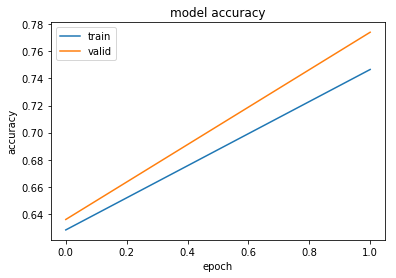

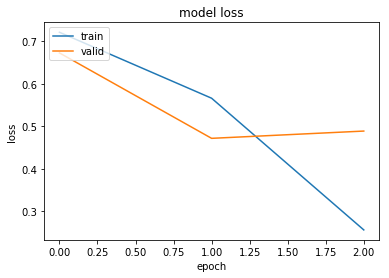

In [39]:
# summarize loss and accuracy

# data in history
print(history.history.keys())

import matplotlib.pyplot as plt
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [40]:
# evaluate on test data
#pred_test = model.predict(test_x)
scores = model.evaluate(test_x, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 81.32%
